## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Regularization strengths
reg_strength = 0.05

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )
    
    uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='tanh',
    )
    
    uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='sigmoid',
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 600.5185
[iteration 0101] loss: 352.4489
[iteration 0201] loss: 238.3154
[iteration 0301] loss: 159.1615
[iteration 0401] loss: 238.9522
[iteration 0501] loss: 162.0307
[iteration 0601] loss: 166.8496
[iteration 0701] loss: 166.2382
[iteration 0801] loss: 153.8624
[iteration 0901] loss: 158.5802
[iteration 1001] loss: 177.1531
[iteration 1101] loss: 129.5743
[iteration 1201] loss: 164.0803
[iteration 1301] loss: 252.0534
[iteration 1401] loss: 113.5786
[iteration 1501] loss: 120.4902
[iteration 1601] loss: 169.5446
[iteration 1701] loss: 116.8175
[iteration 1801] loss: 126.1459
[iteration 1901] loss: 92.4152
[iteration 2001] loss: 99.473

## Plot the results

testing time = 0.41905999183654785 seconds

Mean = tensor([-45.3753, -44.9546, -42.8127, -40.3460, -38.5969, -37.0635, -36.8111,
        -35.1293, -33.0538, -31.5321, -30.7386, -28.9748, -26.8485, -25.6921,
        -24.0006, -22.7794, -21.0947, -19.5005, -17.7717, -16.5250, -14.9865,
        -13.4290, -11.5032, -10.2677,  -8.9281,  -7.2626,  -5.8955,  -4.2427,
         -3.8435,  -3.5783,  -3.2818,  -2.9099,  -2.6026,  -2.2775,  -1.9588,
         -1.6375,  -1.4871,  -1.1917,  -0.9492,  -0.7515,  -0.5624,  -0.3375,
         -0.1410,   0.0641,   0.2770,   0.4975,   0.7296,   0.9366,   1.1739,
          1.3060,   1.4571,   1.5246,   1.5735,   1.6141,   1.6466,   1.6915,
          1.7136,   1.7402,   1.7258,   1.7529,   1.7659,   1.8441,   1.8663,
          1.8468,   1.9021,   1.8758,   1.9337,   1.9406,   2.1080,   2.7901,
          3.5543,   4.3707,   5.1289,   5.8918,   6.6456,   7.5116,   8.1202,
          8.8811,   9.9613,  10.7871,  11.9899,  13.5072,  15.3717,  16.9882,
         18.7

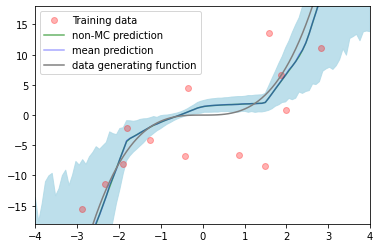

testing time = 0.471282958984375 seconds

Mean = tensor([-43.4106, -41.6179, -40.4391, -40.0227, -39.4630, -37.2101, -36.3915,
        -34.8571, -33.4795, -31.9517, -29.9053, -28.6440, -27.3027, -25.1354,
        -22.6369, -21.6294, -19.9522, -18.3319, -16.8818, -15.3007, -14.0758,
        -12.7284, -11.7123, -10.3586,  -9.0949,  -7.9499,  -7.1206,  -6.2516,
         -5.5971,  -4.6388,  -4.0566,  -3.3132,  -2.8922,  -2.3011,  -2.0629,
         -1.6557,  -1.1716,  -1.0729,  -0.4844,  -0.3414,  -0.0562,   0.1399,
          0.2419,   0.4173,   0.5965,   0.6880,   0.8003,   0.9076,   1.1722,
          1.2287,   1.2452,   1.4242,   1.5949,   1.6132,   1.6310,   1.7391,
          1.8505,   1.8899,   1.9904,   2.1347,   2.3042,   2.3819,   2.6155,
          2.8024,   2.9557,   3.0569,   3.4123,   3.6075,   3.9874,   4.2144,
          4.7071,   5.1845,   5.6822,   6.2438,   6.7691,   7.4998,   8.1596,
          9.1687,  10.3626,  11.3687,  12.0939,  13.6953,  14.5414,  16.5013,
         18.237

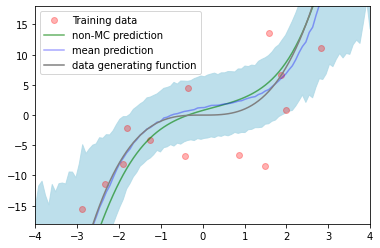

testing time = 0.4126558303833008 seconds

Mean = tensor([-25.5963, -26.0557, -25.2150, -24.8084, -24.8514, -24.3474, -24.2043,
        -23.8592, -22.7762, -22.8390, -22.1837, -21.7125, -21.5714, -21.0751,
        -20.8811, -20.5349, -19.4997, -18.8688, -18.9278, -18.1334, -17.3404,
        -17.0747, -16.5068, -15.8463, -15.5163, -14.9435, -14.6210, -13.7445,
        -13.3582, -13.0784, -12.4699, -11.5060, -11.3439, -10.8308, -10.0529,
         -9.5394,  -9.0750,  -8.5736,  -7.9994,  -7.4052,  -6.9400,  -6.2887,
         -5.6106,  -5.0841,  -4.5647,  -3.9530,  -3.3135,  -2.8150,  -2.1240,
         -1.5221,  -0.9706,  -0.3661,   0.2101,   0.8651,   1.4495,   2.0566,
          2.7180,   3.3721,   3.9484,   4.5917,   5.3349,   5.8179,   6.7156,
          7.2445,   7.9121,   8.8234,   9.3522,  10.0081,  10.8235,  11.5370,
         12.0946,  12.7368,  13.4416,  14.5168,  14.6007,  15.7521,  16.3375,
         16.9463,  17.8549,  18.7423,  19.2926,  19.9770,  20.5212,  21.3019,
         22.31

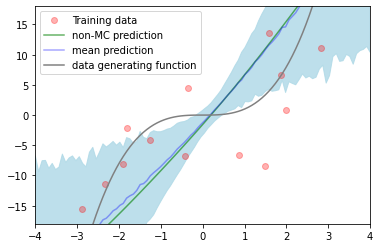

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()